# Exploration of NCD topology

Queries to obtain the CSV files:

`graphs.csv`:
`SELECT lbltype, compid, ncd_formula, dist_aggregator, seqpart, seqid_1, seqid_2, seqid_train, lbl, dist FROM PairwiseDistances JOIN Labels JOIN Sequences WHERE Labels.seqid = seqid_train AND Sequences.seqid = seqid_1`

`traingraph.csv` :
`SELECT lbltype, compid, ncd_formula, seqid_other, seqid_train, LblTrain.lbl, ncd_value from TrainingPairings JOIN Sequences ON Sequences.seqid = seqid_other JOIN Labels AS LblTrain ON LblTrain.seqid = seqid_train WHERE seqpart > 0`

`labels.csv`:
`SELECT lbltype, seqid, lbl FROM Labels`

`seqs.csv` :
`SELECT seqid, seqpart, GROUP_CONCAT(tokval, ' ') AS seq FROM Sequences NATURAL JOIN SequenceValues NATURAL JOIN Alphabet GROUP BY seqid`

In [238]:
import math
import sqlite3 as sql
import dask.dataframe as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
FOLDER = 'E:/diss/reuters/'
GRAPHS = 'C:/Users/Mr Barrett/Dropbox/Diss/graphs/'

In [3]:
LBLTYPE = 86  # wheat
COMPNAME = 0
NCD_FORMULA = "norm-inf-dist-1"

In [4]:
df = pd.read_csv(FOLDER + "graphs.csv")
df = df[(df["compid"] == COMPNAME) & (df["ncd_formula"] == NCD_FORMULA) & (df["seqpart"] == 1)].compute()

In [8]:
df["weight"] = 1.0 / df["dist"]
df

,compid,ncd_formula,dist_aggregator,seqpart,seqid_1,seqid_2,seqid_train,dist,weight
1143566,0,norm-inf-dist-1,mp,1,0,2,3976,1.804914,0.554043
1143567,0,norm-inf-dist-1,mp,1,2,0,3976,1.804914,0.554043
1143568,0,norm-inf-dist-1,mp,1,0,4,3325,1.799317,0.555766
1143569,0,norm-inf-dist-1,mp,1,4,0,3325,1.799317,0.555766
1143570,0,norm-inf-dist-1,mp,1,0,6,3459,1.831853,0.545895
...,...,...,...,...,...,...,...,...,...
834713,0,norm-inf-dist-1,mp,1,3016,3014,7051,1.682795,0.594249
834714,0,norm-inf-dist-1,mp,1,3014,3018,3063,1.658857,0.602825
834715,0,norm-inf-dist-1,mp,1,3018,3014,3063,1.658857,0.602825
834718,0,norm-inf-dist-1,mp,1,3016,3018,7051,1.512498,0.661158


In [6]:
df["seqid_train"].nunique()

358

In [5]:
lbls = pd.read_csv(FOLDER + "labels.csv").compute()
lbls = { (row["lbltype"], row["seqid"]) : row["lbl"] for index, row in lbls.iterrows() }

In [42]:
categories = pd.read_csv(FOLDER + "categories.csv").compute()
categories = { row["seqid"] : row["categories"] for index, row in categories.iterrows() }

In [6]:
seqs = pd.read_csv(FOLDER + "seqs.csv").set_index("seqid")
seqs.head(5)

,seqpart,seq
seqid,,
0,1,[CLS] asian export ##ers fear damage from u . ...
1,2,[CLS] china daily says ve ##rmin eat 7 - 12 pc...
2,1,[CLS] japan to rev ##ise long - term energy de...
3,2,[CLS] thai trade deficit widen ##s in first qu...
4,1,[CLS] indonesia sees cp ##o price rising sharp...


In [9]:
G = nx.from_pandas_edgelist(df, "seqid_1", "seqid_2", ["weight", "dist", "seqid_train"])
G_mst = nx.minimum_spanning_tree(G, weight="dist")

In [25]:
lbl_counts = [0, 0]
for seqid in G.nodes():
    lbl_counts[lbls[(LBLTYPE, seqid)]] += 1

print("Baseline accuracy:", max(lbl_counts) / sum(lbl_counts))

Baseline accuracy: 0.9781456953642385


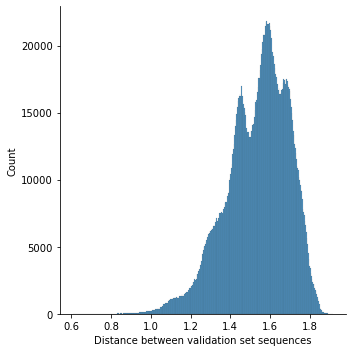

In [296]:
sns.displot(df["dist"])
plt.xlabel('Distance between validation set sequences')
plt.savefig(GRAPHS + f"reuters-ncd-dist.svg", format="svg", bbox_inches='tight')

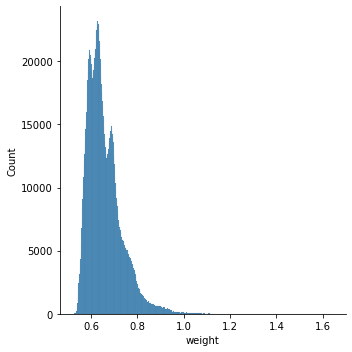

In [12]:
sns.displot(df["weight"])

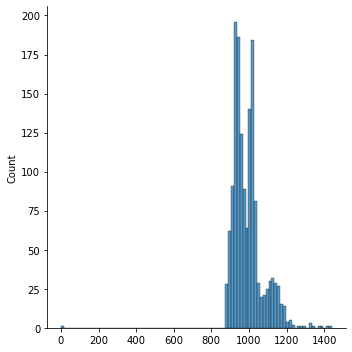

In [13]:
sns.displot(nx.laplacian_spectrum(G))

In [26]:
node_colours = [('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') for node in G.nodes()]
edge_opacities = list(nx.get_edge_attributes(G, "weight").values())
edge_opacities = [0.0 if a < 1.0 else 0.2 * (a - 1.0) / 3.0 for a in edge_opacities]

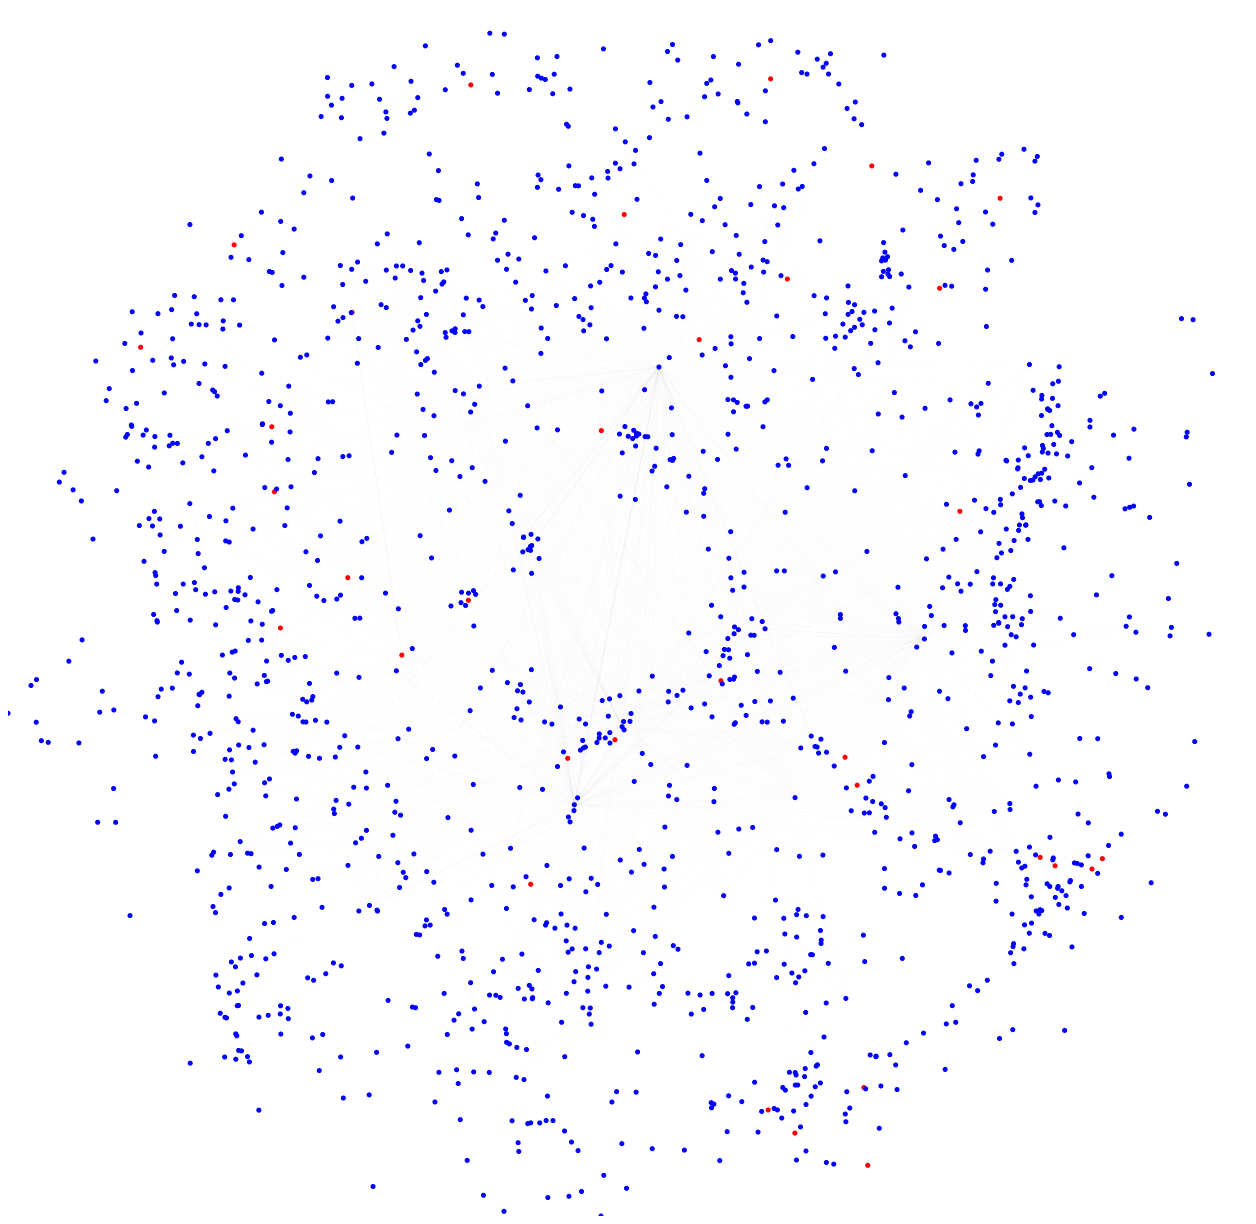

In [27]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G, weight="weight")
nx.draw_networkx_nodes(G, pos, node_shape='.', node_size=50, node_color=node_colours)
nx.draw_networkx_edges(G, pos, alpha=edge_opacities)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [101]:
print("Degrees:")
for node in G_mst.nodes():
    if G_mst.degree[node] > 1:
        print(node, G_mst.degree[node], categories[node])

Degrees:
490 1040 oilseed rapeseed
684 5 dlr money-fx
820 8 lei
1702 220 income
1756 108 earn
1880 3 interest
1906 3 acq
2306 127 earn
2742 3 corn grain oilseed soybean wheat


In [ ]:
wheat_lbltype = 86
grain_lbltype = 26

In [289]:
lbltype = 86
xs, ys = [], []
for (u, v) in G_mst.edges():
    G_removed = G_mst.copy()
    G_removed.remove_edge(u, v)
    f1s = []
    CCs = list(nx.connected_components(G_removed))
    assert(len(CCs) == 2)
    for C in CCs:
        tp, fp, tn, fn = 0, 0, 0, 0
        for node in G_mst.nodes():
            if lbls[(lbltype, node)] == 1:
                if node in C:
                    tp += 1
                else:
                    fn += 1
            else:  # if lbls[(lbltype, node)] == 0
                if node not in C:
                    tn += 1
                else:
                    fp += 1

        xs.append(tp / (tp + fn))
        ys.append(tp / (tp + fp))

In [290]:
class_freq = 0
for node in G_mst.nodes():
    class_freq += lbls[(lbltype, node)]
class_freq /= len(G_mst.nodes())

In [291]:
xs = np.array([1.0, 0.0, 0.0] + xs)
ys = np.array([0.0, 1.0, 0.0] + ys)

# only include Pareto optimal
# pairs, AKA convex hull
hull = ConvexHull(np.stack((xs, ys), axis=-1))

In [292]:
set(zip(xs, ys))

{(0.0, 0.0),
 (0.0, 1.0),
 (0.030303030303030304, 1.0),
 (0.09090909090909091, 1.0),
 (0.2727272727272727, 0.019148936170212766),
 (0.2727272727272727, 0.04054054054054054),
 (0.7272727272727273, 0.018633540372670808),
 (0.7272727272727273, 0.023076923076923078),
 (0.9090909090909091, 0.019907100199071003),
 (0.9696969696969697, 0.021206096752816435),
 (1.0, 0.0),
 (1.0, 0.02186878727634195),
 (1.0, 0.021897810218978103),
 (1.0, 0.021956087824351298),
 (1.0, 0.021970705725699067),
 (1.0, 0.023758099352051837),
 (1.0, 0.026128266033254157)}

In [293]:
hull.volume - 0.5 * (1.0 + class_freq) * 1.0

0.04640387769723475

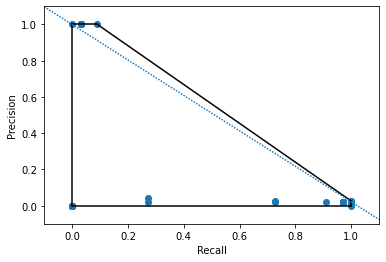

In [295]:
plt.plot(xs, ys, 'o')
for simplex in hull.simplices:
    plt.plot(xs[simplex], ys[simplex], 'k-')
plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axline((1.0, class_freq), (0.0, 1.0), dashes=(1.0, 1.0))
plt.savefig(GRAPHS + f"reuters-lbltype{lbltype}-pr-curve.svg", format="svg", bbox_inches='tight')
plt.show()

In [10]:
# cache here so we can recolour
pos = nx.spring_layout(G_mst, weight=None)

In [97]:
def get_nbh_summary(node):
    if G_mst.degree[node] < 10:
        cats = set(categories[node].split(" "))
        for n in list(G_mst.neighbors(node)):
            if G_mst.degree[n] == 1:
                for cat in categories[n].split(" "):
                    cats.add(cat)
        return "\n".join(cats) + "\nNode " + str(node)
    else:
        return "Node " + str(node)

In [90]:
def get_text_pos(node):
    x, y = pos[seqid][0] + 0.02, pos[seqid][1] - 0.1
    while min([
        ((x - px) ** 2.0 + (y - py) ** 2.0) ** 0.5
        for px, py in pos.values()
    ]) < 0.05:
        y -= 0.05
    return x, y

In [266]:
node_colours = [('red' if lbls[(0, node)] == 1
                 else 'blue') for node in G.nodes()]
node_opacities = list(map(lambda s: 1.0, node_colours))

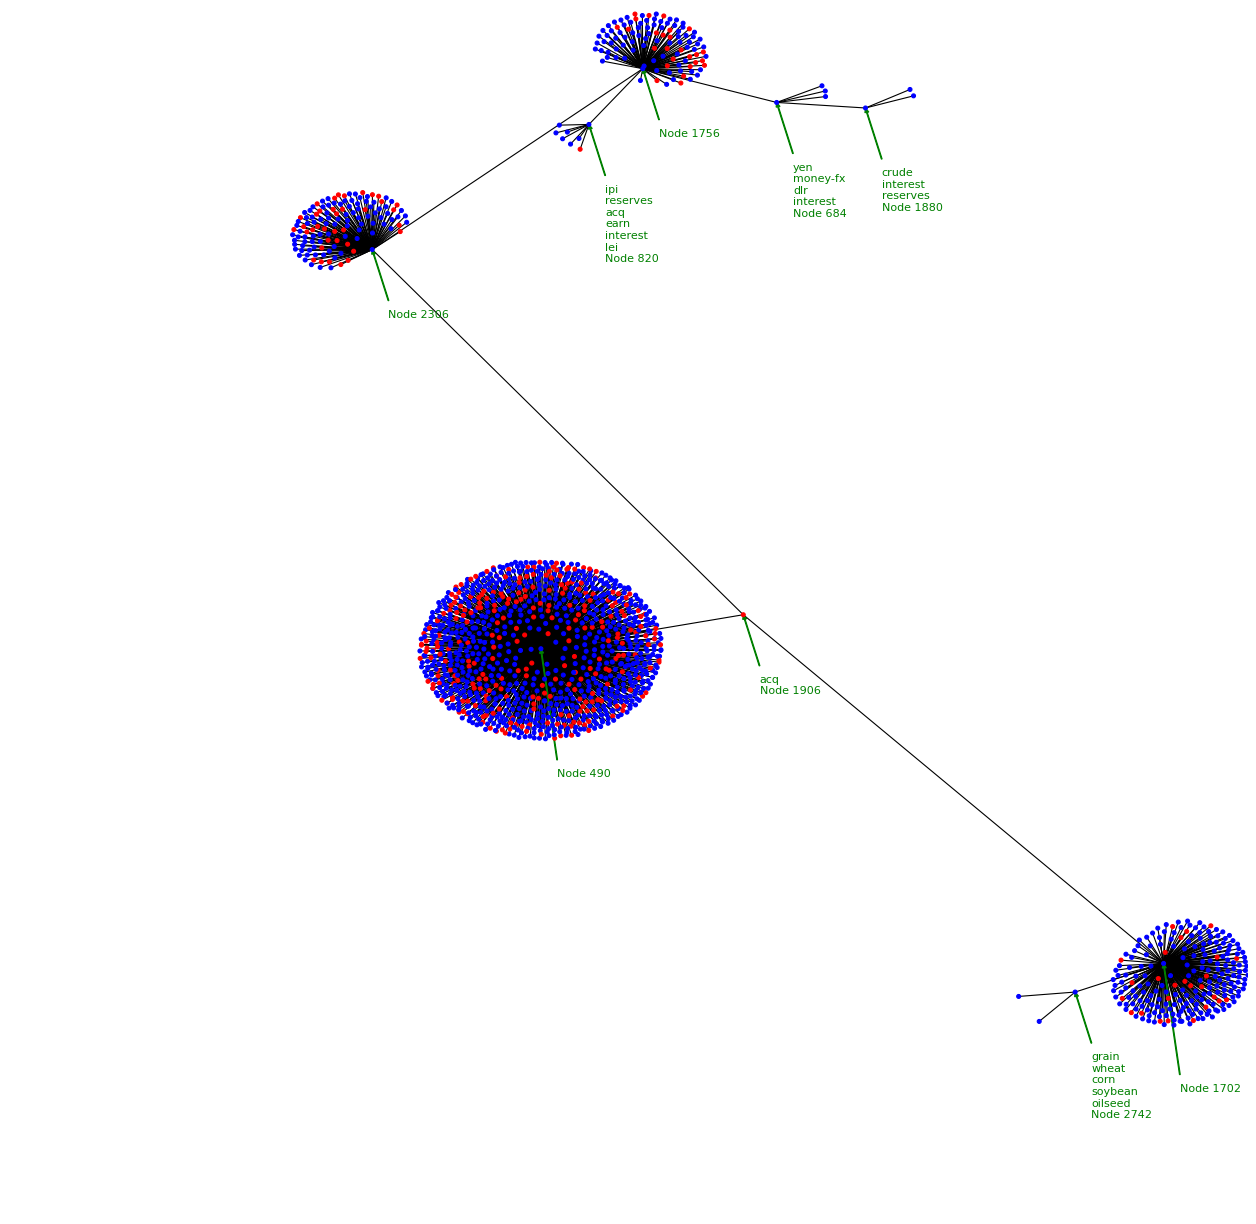

In [267]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
nx.draw_networkx_nodes(G_mst, pos, node_shape='.', node_size=50,
                       node_color=node_colours, alpha=node_opacities)
nx.draw_networkx_edges(
    G_mst, pos,
    edge_color='black'
)
# Text plotting
for seqid in G_mst.nodes():
    if G_mst.degree[seqid] > 1:
        text_pos = get_text_pos(seqid)
        plt.text(text_pos[0], text_pos[1],
                 get_nbh_summary(seqid), color='g',
                 verticalalignment='top')
        dy = 0.015
        plt.arrow(text_pos[0], text_pos[1] + dy,
                  pos[seqid][0] - text_pos[0],
                  pos[seqid][1] - text_pos[1] - dy,
                  color='g', width=1.0e-3, head_width=5.0e-3,
                  length_includes_head=True)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax + 0.01)
plt.savefig(GRAPHS + "reuters-mst.svg", format="svg", bbox_inches='tight')
plt.show()

In [ ]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G_mst.nodes():
    # vote on neighbouring edge labels on that node in the MST
    cur_lbls = {}
    for _, _, seqid_train in G_mst.edges(seqid, data="seqid_train"):
        lbl = lbls[(LBLTYPE, seqid_train)]
        if lbl not in cur_lbls:
            cur_lbls[lbl] = 0
        cur_lbls[lbl] += 1

    # get highest vote
    max_count = -1
    max_lbl = None
    for lbl, n in cur_lbls.items():
        if n > max_count:
            max_count = n
            max_lbl = lbl

    if len(G_mst.edges(seqid)) > 1:
        print("Votes for central node", seqid, "with true label",
              lbls[(LBLTYPE, seqid)], "are", cur_lbls, ". Classified as", max_lbl, ".")
        print("Central node reads", seqs.loc[seqid]["seq"].compute().values[0])
    conf_matrix[lbls[(LBLTYPE, seqid)]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / len(G_mst.nodes()))
print("F1:", conf_matrix[1][1] / (conf_matrix[1][1] + 0.5 * (conf_matrix[1][0] + conf_matrix[0][1])))

In [18]:
df2 = pd.read_csv(FOLDER + "traingraph.csv")
df2 = df2[(df2["compid"] == COMPNAME) & (df2["ncd_formula"] == NCD_FORMULA)]

In [19]:
# add training labels to `lbls`
# and also keep track of which are training nodes
train_nodes = set()
for seqid_train, _ in seqs[seqs["seqpart"] == 0].iterrows():
    train_nodes.add(seqid_train)

In [20]:
G2 = nx.from_pandas_edgelist(df2, "seqid_other", "seqid_train", ["ncd_value"])
G2_mst = nx.minimum_spanning_tree(G2, weight="ncd_value")

In [ ]:
node_colours2 = [
    ('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') if node not in train_nodes
    else 'black'
    for node in G2.nodes()
]
edge_colours2 = [
    ('blue' if lbls[(LBLTYPE, u)] == 0 else 'red') if u in train_nodes
    else ('blue' if lbls[(LBLTYPE, v)] == 0 else 'red')
    for (u, v) in G2_mst.edges()
]

plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G2_mst, weight=None)
nx.draw_networkx_nodes(G2_mst, pos, node_size=50, node_shape='.',
                       node_color=node_colours2)
nx.draw_networkx_edges(
    G2_mst, pos,
    edge_color=edge_colours2
)
#for seqid in G2_mst.nodes():
#    if G2_mst.degree[seqid] > 1 and seqs[seqs.index == seqid]["seqpart"].iloc[0] > 0:
#        plt.text(pos[seqid][0], pos[seqid][1],
#                 seqs.loc[seqid]["seq"].compute().values[0])
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [ ]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G2_mst.nodes():
    if seqid in train_nodes:
        continue  # skip training nodes

    # vote on neighbouring edge labels on that node in the MST
    cur_lbls = {}
    for seqid_train in G2_mst.neighbors(seqid):
        lbl = lbls[(LBLTYPE, seqid_train)]
        if lbl not in cur_lbls:
            cur_lbls[lbl] = 0
        cur_lbls[lbl] += 1

    # get highest vote
    max_count = -1
    max_lbl = None
    for lbl, n in cur_lbls.items():
        if n > max_count:
            max_count = n
            max_lbl = lbl

    conf_matrix[lbls[(LBLTYPE, seqid)]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / len(G2_mst.nodes()))
print("F1:", conf_matrix[1][1] / (conf_matrix[1][1] + 0.5 * (conf_matrix[1][0] + conf_matrix[0][1])))

In [ ]:
lbl_bool = df2["seqid_train"].apply(lambda seqid_train: lbls[(LBLTYPE, seqid_train)] == 0, meta=('seqid_train', 'bool'))

G3a = nx.from_pandas_edgelist(df2[lbl_bool], "seqid_other", "seqid_train", ["ncd_value"])
G3a_mst = nx.minimum_spanning_tree(G3a, weight="ncd_value")

G3b = nx.from_pandas_edgelist(df2[~lbl_bool], "seqid_other", "seqid_train", ["ncd_value"])
G3b_mst = nx.minimum_spanning_tree(G3b, weight="ncd_value")

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G3a_mst, weight=None)
nx.draw_networkx_nodes(G3a_mst, pos, node_size=50, node_shape='.',
                       node_color=[('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') for node in G3a_mst.nodes()])
nx.draw_networkx_edges(
    G3a_mst, pos
)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [ ]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G3b_mst, weight=None)
nx.draw_networkx_nodes(G3b_mst, pos, node_size=50, node_shape='.',
                       node_color=[('blue' if lbls[(LBLTYPE, node)] == 0 else 'red') for node in G3b_mst.nodes()])
nx.draw_networkx_edges(
    G3b_mst, pos
)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [ ]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G3a_mst.nodes():
    if seqid in train_nodes:
        continue  # skip training nodes

    degree_a, degree_b = len(G3a_mst.edges(seqid)), len(G3b_mst.edges(seqid))
    if degree_b > 2:
        print(seqid)
        max_lbl = 1
    else:
        max_lbl = 0
    #if degree_a > degree_b:
    #    max_lbl = 0
    #else:
    #    max_lbl = 1

    #if abs(degree_a - degree_b) > 1:
    #    print("Decisive node seqid=", seqid, "had degrees", degree_a, degree_b, "with true label", lbls[(LBLTYPE, seqid)])
    #    print("Decisive node reads", seqs.loc[seqid]["seq"].compute().values[0])
    conf_matrix[lbls[(LBLTYPE, seqid)]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / sum(conf_matrix[0] + conf_matrix[1]))
print("F1:", conf_matrix[1][1] / (conf_matrix[1][1] + 0.5 * (conf_matrix[1][0] + conf_matrix[0][1])))